## Import Libraries

In [1]:
from glob import glob
from time import time
from random import randrange
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

## Import Data

In [194]:
#df = pd.read_csv('input_data/goodreads_books.csv') 

In [2]:
files = glob("input_data/goodreads_books_chunk_*.csv")

list_df = []

for filename in files:
    df = pd.read_csv(filename, index_col=None, header=0)
    list_df.append(df)

df = pd.concat(list_df, axis=0, ignore_index=True)

In [3]:
df.head()

,id,title,link,series,cover_link,author,author_link,rating_count,review_count,average_rating,...,isbn13,asin,settings,characters,awards,amazon_redirect_link,worldcat_redirect_link,recommended_books,books_in_series,description
0,630104,Inner Circle,https://www.goodreads.com//book/show/630104.In...,(Private #5),https://i.gr-assets.com/images/S/compressed.ph...,"Kate Brian, Julian Peploe",https://www.goodreads.com/author/show/94091.Ka...,7597,196,4.03,...,9781416950417,NaN,NaN,NaN,NaN,https://www.goodreads.com//book_link/follow/17...,https://www.goodreads.com//book_link/follow/8?...,"726458, 726458, 1537534, 3047848, 1651302, 304...","381489, 381501, 352428, 630103, 1783281, 17832...",Reed Brennan arrived at Easton Academy expecti...
1,9487,A Time to Embrace,https://www.goodreads.com//book/show/9487.A_Ti...,(Timeless Love #2),https://i.gr-assets.com/images/S/compressed.ph...,Karen Kingsbury,https://www.goodreads.com/author/show/3159984....,4179,177,4.35,...,9781595542328,NaN,NaN,NaN,NaN,https://www.goodreads.com//book_link/follow/17...,https://www.goodreads.com//book_link/follow/8?...,"127352, 127352, 40642197, 127353, 127354, 3891...",115036,"Ideje az Ã¶lelÃ©snek TÃ¶rtÃ©net a remÃ©nyrÅl,..."
2,6050894,Take Two,https://www.goodreads.com//book/show/6050894-t...,(Above the Line #2),https://i.gr-assets.com/images/S/compressed.ph...,Karen Kingsbury,https://www.goodreads.com/author/show/3159984....,6288,218,4.23,...,NaN,NaN,"Bloomington, Indiana(United States)",NaN,NaN,https://www.goodreads.com//book_link/follow/17...,https://www.goodreads.com//book_link/follow/8?...,"706250, 706250, 666481, 11942636, 706241, 1273...","4010795, 40792877, 7306261",Filmmakers Chase Ryan and Keith Ellison have c...
3,39030,Reliquary,https://www.goodreads.com//book/show/39030.Rel...,(Pendergast #2),https://i.gr-assets.com/images/S/compressed.ph...,"Douglas Preston, Lincoln Child",https://www.goodreads.com/author/show/12577.Do...,38382,1424,4.01,...,9780765354952,NaN,"New York State(United States) New York City, N...","Aloysius X.L. Pendergast, Margo Green, William...",NaN,https://www.goodreads.com//book_link/follow/17...,https://www.goodreads.com//book_link/follow/8?...,"39026, 39026, 11007668, 3986318, 51887330, 194...","67035, 39031, 39033, 136637, 136638, 30068, 39...",NaN
4,998,The Millionaire Next Door: The Surprising Secr...,https://www.goodreads.com//book/show/998.The_M...,NaN,https://i.gr-assets.com/images/S/compressed.ph...,"Thomas J. Stanley, William D. Danko",https://www.goodreads.com/author/show/659.Thom...,72168,3217,4.04,...,9780671015206,NaN,NaN,NaN,Independent Publisher Book Award (IPPY) Nomine...,https://www.goodreads.com//book_link/follow/17...,https://www.goodreads.com//book_link/follow/8?...,"1052, 1052, 763362, 69571, 78427, 30186948, 10...",NaN,The incredible national bestseller that is cha...


## Preprocessing

### Generating New Columns

### Step 1: 
Create new column **if book is part of a series (1) or not (0)**. By this, missing values are treated as a valuable information itself (0 = book is not part of a series). 
Assuming the column 'series' is reliably filled.

In [55]:
#df.insert(4, 'is_part_of_series', df.series.notna().astype(int))

### Step 2:
Create new column **by how many authors the book was written**. To this end, comma-separated units are counted.

In [3]:
df.insert(6, 'number_of_authors', df.author.str.count(',')+1)

### Step 3:
Create new column for **the book's publication year**.

In [4]:
df.insert(1, 'year_published', pd.to_numeric(df['date_published'].str[-4:], errors = 'coerce'))

### Step 4:
Create new column **if book is an award winning book (1) or not (0).** By this, missing values are treated as a valuable information itself (0 = book is not award winning). Assuming the column 'awards' is reliably filled.

In [5]:
df.insert(27, 'is_award_winning', df.awards.notna().astype(int))

### Step 5:
Create new column for the **number of books in the series**. To this end, comma-separated units are counted.

*Please note that the book at hand is not listed in the column 'books_in_series' (+2).*

In [6]:
df.insert(31, 'number_of_books_in_series', df.books_in_series.str.count(',')+2) #note: the book at hand is not listed in 'books_in_series'

### Step 6:
Create consistent representation of missing values in 'number_of_pages' (0 to NaN).

In [7]:
df.number_of_pages = df.number_of_pages.replace(0, np.nan)

### Step 7:
Inspection of the column 'genre_and_votes' reveals the most voted genre to be listed in the first position.

In [262]:
#inspect a random sample (n=10)
random_int = randrange(start=0, stop=df.shape[0]-10)
print(df.genre_and_votes[random_int:random_int+10])

2240    Romance-Historical Romance 1276, Romance 1056,...
2241    Young Adult 52, New Adult 23, Music 17, Myster...
2242    Sequential Art-Manga 279, Manga-Yaoi 67, Roman...
2243    Fiction 38, European Literature-Portuguese Lit...
2244    Asian Literature-Turkish Literature 56, Fictio...
2245    Fantasy-Urban Fantasy 118, Fantasy-Paranormal ...
2246    Sequential Art-Comics 2022, Sequential Art-Gra...
2247                            Humor 34, Contemporary 13
2248    Young Adult 153, LGBT 132, Science Fiction-Dys...
2249    Romance-Romantic Suspense 185, Romance 88, Thr...
Name: genre_and_votes, dtype: object


Create two new columns for **the book's main genre** according to readers' votes. To this end, the numerical votes are removed (genre mix) and the first comma-separated unit is extracted **(main genre)**.

In [8]:
df.insert(23, 'main_genre', df.genre_and_votes.replace(to_replace=' [0-9]+', value='', regex=True).str.split(',').str[0])

### Overview of Missing Values

In [264]:
cols_wo_missing_vals = list(df.columns[df.isnull().sum()/df.shape[0] == 0])
cols_w_missing_vals = list(df.columns[df.isnull().sum()/df.shape[0] > 0])

In [265]:
print('List of columns without missing values: {}'.format(cols_wo_missing_vals))

List of columns without missing values: ['id', 'title', 'link', 'author', 'number_of_authors', 'author_link', 'rating_count', 'review_count', 'average_rating', 'five_star_ratings', 'four_star_ratings', 'three_star_ratings', 'two_star_ratings', 'one_star_ratings', 'is_award_winning', 'amazon_redirect_link']


In [266]:
cols_missing_vals_share = df[cols_w_missing_vals].isnull().sum()/df.shape[0]
pd.options.display.max_rows = 25
print(cols_missing_vals_share.sort_values(ascending = False))

asin                         0.899692
awards                       0.796433
settings                     0.779402
characters                   0.737639
number_of_books_in_series    0.577042
books_in_series              0.577042
series                       0.553267
original_title               0.248070
isbn13                       0.243146
isbn                         0.227648
recommended_books            0.076515
worldcat_redirect_link       0.076342
publisher                    0.069657
main_genre                   0.054407
genre_and_votes              0.054407
description                  0.049330
number_of_pages              0.047836
year_published               0.016610
date_published               0.016475
cover_link                   0.011629
dtype: float64


### Removing Columns

In [9]:
remove_cols_list = ['id','title','original_title','link','author_link','amazon_redirect_link','asin','books_in_series','series'
                   ,'isbn','isbn13','worldcat_redirect_link','recommended_books','cover_link','description','characters'
                   ,'genre_and_votes','author','date_published','awards','settings']
df.drop(remove_cols_list, inplace=True, axis=1)

## Data Analysis

In [268]:
print('The preprocessed dataset contains {} rows and {} columns.'.format(df.shape[0],df.shape[1]))

The preprocessed dataset contains 52199 rows and 15 columns.


In [269]:
print('Overview of all numerical columns in the dataset:')
df.describe()

Overview of all numerical columns in the dataset:


,year_published,number_of_authors,rating_count,review_count,average_rating,five_star_ratings,four_star_ratings,three_star_ratings,two_star_ratings,one_star_ratings,number_of_pages,is_award_winning,number_of_books_in_series
count,51332.000000,52199.000000,5.219900e+04,52199.000000,52199.000000,5.219900e+04,5.219900e+04,52199.000000,52199.000000,52199.000000,49702.000000,52199.000000,22078.000000
mean,1988.057508,1.342957,1.887361e+04,1012.980881,4.020610,7.817176e+03,6.250785e+03,3456.512424,935.496600,413.640051,330.047986,0.203567,6.082933
std,121.983274,1.409807,1.163978e+05,4054.802421,0.367161,5.876373e+04,3.473533e+04,18249.298631,5890.077215,3843.356500,252.493106,0.402655,3.338582
min,-850.000000,1.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,1.000000,0.000000,2.000000
25%,1993.000000,1.000000,3.400000e+02,31.000000,3.820000,1.170000e+02,1.090000e+02,63.000000,15.000000,6.000000,212.000000,0.000000,3.000000
50%,2007.000000,1.000000,2.295000e+03,163.000000,4.030000,8.100000e+02,7.650000e+02,452.000000,107.000000,36.000000,304.000000,0.000000,5.000000
75%,2012.000000,1.000000,9.297500e+03,622.000000,4.230000,3.375500e+03,3.190500e+03,1866.000000,450.000000,151.000000,393.000000,0.000000,10.000000
max,2021.000000,52.000000,6.801077e+06,169511.000000,5.000000,4.414877e+06,1.868421e+06,980183.000000,529060.000000,537793.000000,14777.000000,1.000000,11.000000


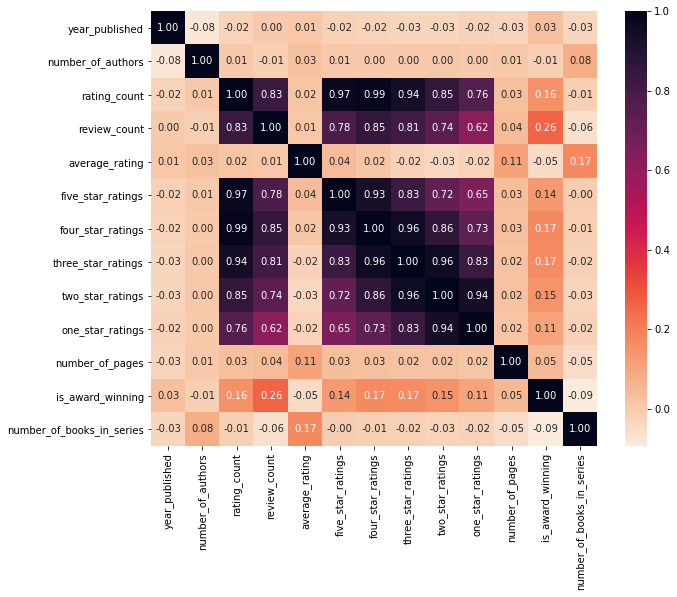

In [ ]:
df_rest = df[(df['year_published']>1800) & (df['year_published']<2020)]

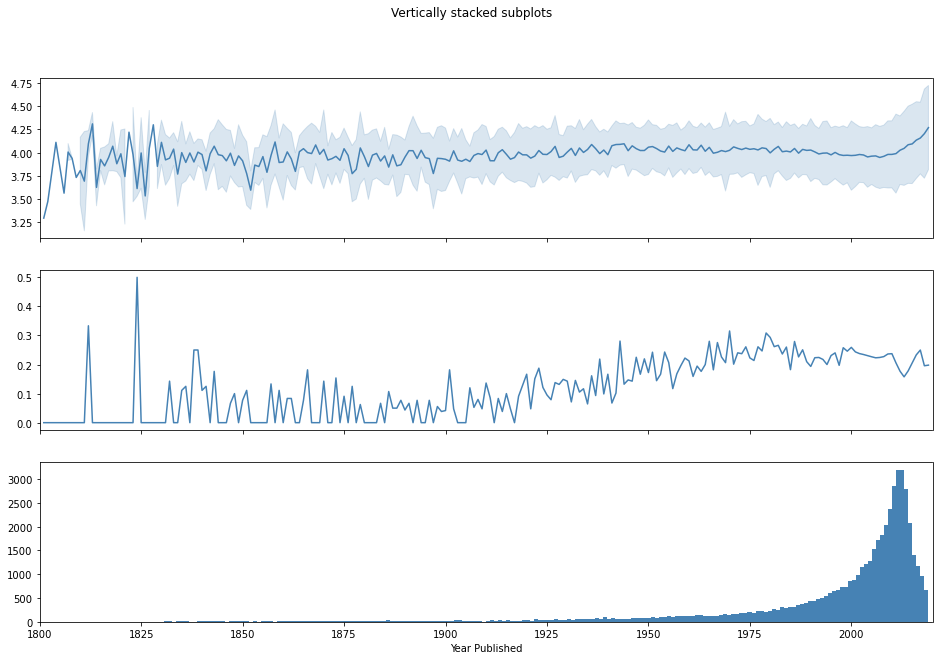

In [156]:
df_count = df_rest[['year_published','average_rating']].groupby('year_published').count().rename(columns={'average_rating': 'book_count'})
df_mean = df_rest[['year_published','average_rating']].groupby('year_published').mean().rename(columns={'average_rating': 'average_rating_mean'})
df_std = df_rest[['year_published','average_rating']].groupby('year_published').std().rename(columns={'average_rating': 'average_rating_std'})
df_sum_award = df_rest[['year_published','is_award_winning']].groupby('year_published').sum().rename(columns={'is_award_winning': 'is_award_winning_sum'})
df_joined_1 = df_count.join(df_mean)
df_joined_2 = df_joined_1.join(df_std)
df_joined = df_joined_2.join(df_sum_award)
df_joined['is_award_winning_share'] = df_joined['is_award_winning_sum']/df_joined['book_count']


fig, ax = plt.subplots(3, figsize=(16, 10), sharex = True)
fig.suptitle('Vertically stacked subplots')

ax[0].plot(df_joined.index, df_joined.average_rating_mean, color = 'steelblue')
ax[0].fill_between(df_joined.index, df_joined.average_rating_mean - df_joined.average_rating_std,
                df_joined.average_rating_mean + df_joined.average_rating_std,
                alpha = 0.2, color = 'steelblue')
#ax[0].tick_params(labelbottom = True)

ax[1].plot(df_joined.index, df_joined.is_award_winning_share, color = 'steelblue')

ax[2].hist(df_rest.year_published, bins=220, color = 'steelblue')
ax[2].set_xlim(1800,2020)
ax[2].set(xlabel = 'year_published'.replace('_',' ').title())
plt.show()


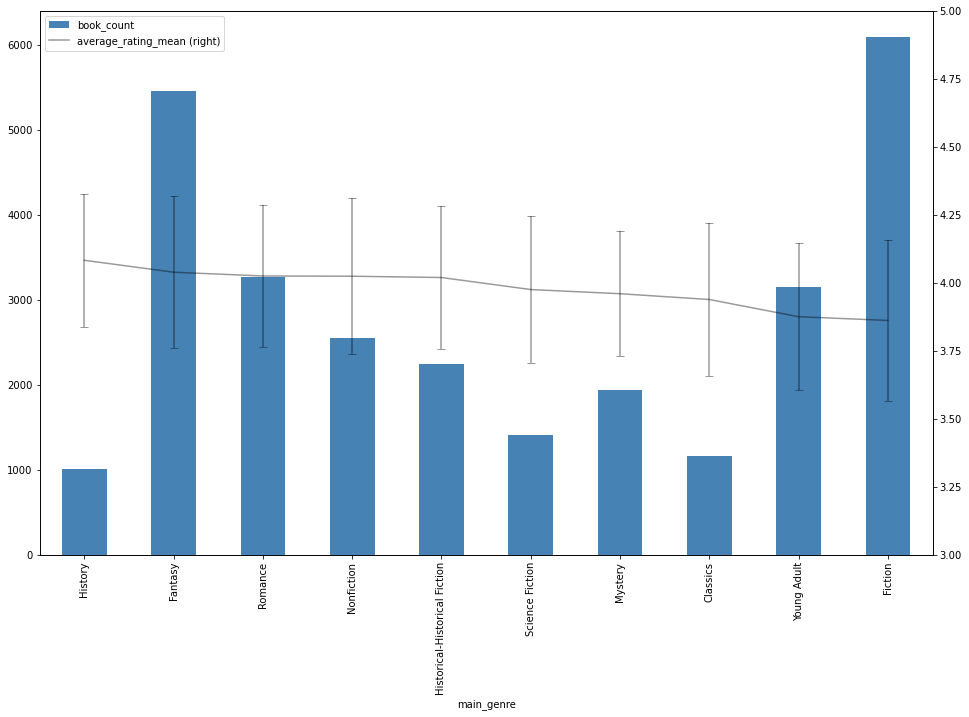

In [154]:
df_top_genres = df.groupby('main_genre').filter(lambda x: len(x) >= 1000)
df_count = df_top_genres[['main_genre','average_rating']].groupby('main_genre').count().rename(columns={'average_rating': 'book_count'})
df_mean = df_top_genres[['main_genre','average_rating']].groupby('main_genre').mean().rename(columns={'average_rating': 'average_rating_mean'})
df_std = df_top_genres[['main_genre','average_rating']].groupby('main_genre').std().rename(columns={'average_rating': 'average_rating_std'})
df_joined_1 = df_count.join(df_mean)
df_joined = df_joined_1.join(df_std).sort_values('average_rating_mean', ascending = False)

fig, ax = plt.subplots(figsize=(16, 10))
df_joined.plot(ax=ax, y='book_count', kind='bar', color='steelblue')
# same ax as above - automatically added on the right
df_joined.plot(ax=ax,
               y='average_rating_mean',
               secondary_y=True,
               yerr='average_rating_std',
               color='black',
               alpha=0.4,
               capsize=4)
ax.tick_params(axis='x',labelrotation=90)
ax.right_ax.set_ylim(3,5)
plt.show()

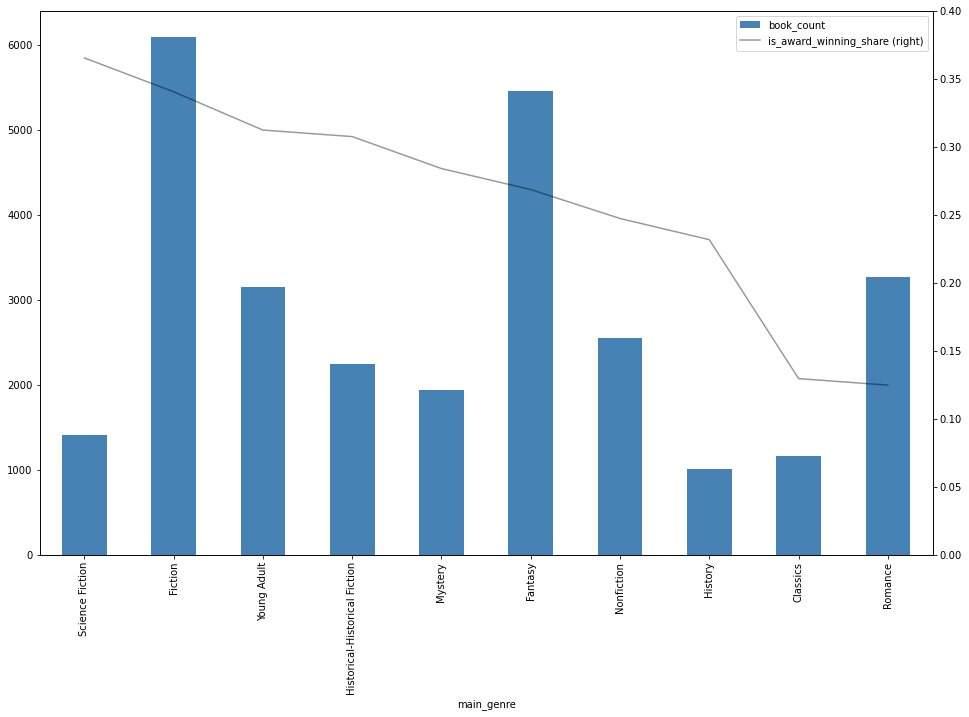

In [183]:
df_top_genres = df.groupby('main_genre').filter(lambda x: len(x) >= 1000)
df_count = df_top_genres[['main_genre','is_award_winning']].groupby('main_genre').count().rename(columns={'is_award_winning': 'book_count'})
df_sum = df_top_genres[['main_genre','is_award_winning']].groupby('main_genre').sum().rename(columns={'is_award_winning': 'is_award_winning_sum'})
df_joined = df_count.join(df_sum)
df_joined['is_award_winning_share'] = df_joined['is_award_winning_sum']/df_joined['book_count']
df_joined = df_joined.sort_values('is_award_winning_share', ascending = False)

fig, ax = plt.subplots(figsize=(16, 10))
df_joined.plot(ax=ax, y='book_count', kind='bar', color='steelblue')
# same ax as above - automatically added on the right
df_joined.plot(ax=ax,
               y='is_award_winning_share',
               secondary_y=True,
               color='black',
               alpha=0.4)
ax.tick_params(axis='x',labelrotation=90)
ax.right_ax.set_ylim(0,0.4)
plt.show()

(2000.0, 2020.0)

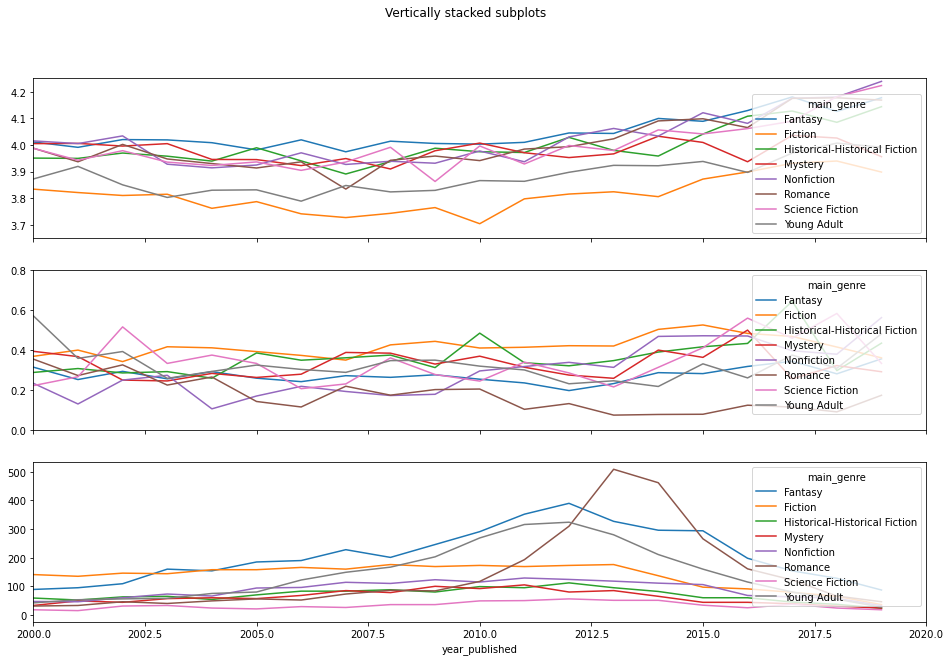

In [145]:
df_top_genres = df_rest.groupby('main_genre').filter(lambda x: len(x) >= 1000)
df_count = df_top_genres[['year_published','main_genre','average_rating']].groupby(['year_published','main_genre']).count().rename(columns={'average_rating': 'book_count'})
df_mean = df_top_genres[['year_published','main_genre','average_rating']].groupby(['year_published','main_genre']).mean().rename(columns={'average_rating': 'average_rating_mean'})
df_std = df_top_genres[['year_published','main_genre','average_rating']].groupby(['year_published','main_genre']).std().rename(columns={'average_rating': 'average_rating_std'})
df_sum_awards = df_top_genres[['year_published','main_genre','is_award_winning']].groupby(['year_published','main_genre']).sum().rename(columns={'is_award_winning': 'is_award_winning_sum'})

df_joined_1 = df_count.join(df_mean)
df_joined_2 = df_joined_1.join(df_std)
df_joined = df_joined_2.join(df_sum_awards)
df_joined['is_award_winning_share'] = df_joined['is_award_winning_sum']/df_joined['book_count']

fig, ax = plt.subplots(3, figsize=(16, 10), sharex = True)
fig.suptitle('Vertically stacked subplots')

df_joined['average_rating_mean'].unstack().plot(ax=ax[0])
ax[0].set_ylim(3.65,4.25)

df_joined['is_award_winning_share'].unstack().plot(ax=ax[1])
ax[1].set_ylim(0,0.8)

df_joined['book_count'].unstack().plot(ax=ax[2])
ax[2].set_xlim(2000,2020)

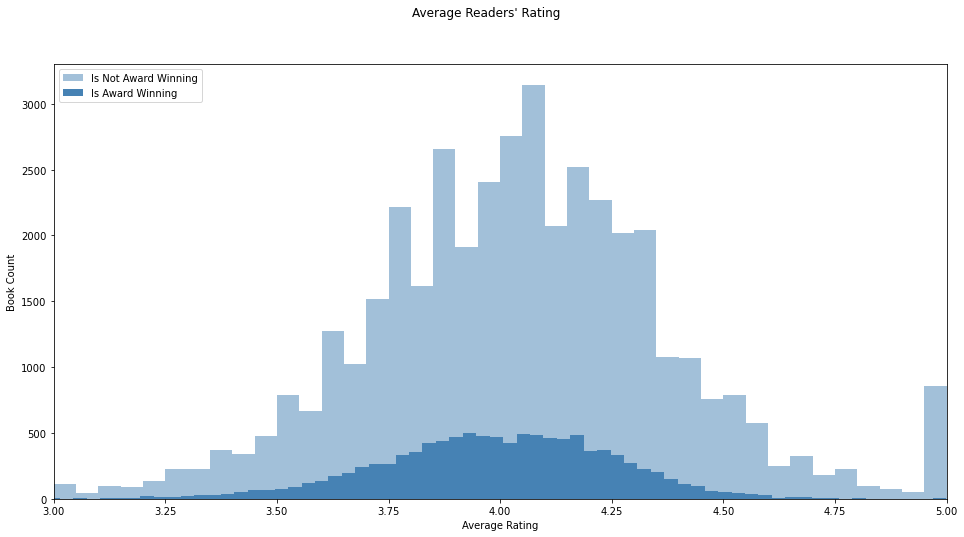

In [188]:
fig, ax = plt.subplots(figsize=(16, 8))
fig.suptitle("Average Readers' Rating")
ax.hist(df.average_rating[df.is_award_winning == 0], bins=100, alpha = 0.5, color = 'steelblue', label='is_not_award_winning'.replace('_',' ').title())
ax.hist(df.average_rating[df.is_award_winning == 1], bins=100, alpha = 1, color = 'steelblue', label='is_award_winning'.replace('_',' ').title())
ax.legend(loc='upper left')
ax.set(xlabel = 'average_rating'.replace('_',' ').title())
ax.set(ylabel = 'book_count'.replace('_',' ').title())
ax.set_xlim([3, 5])
plt.show()

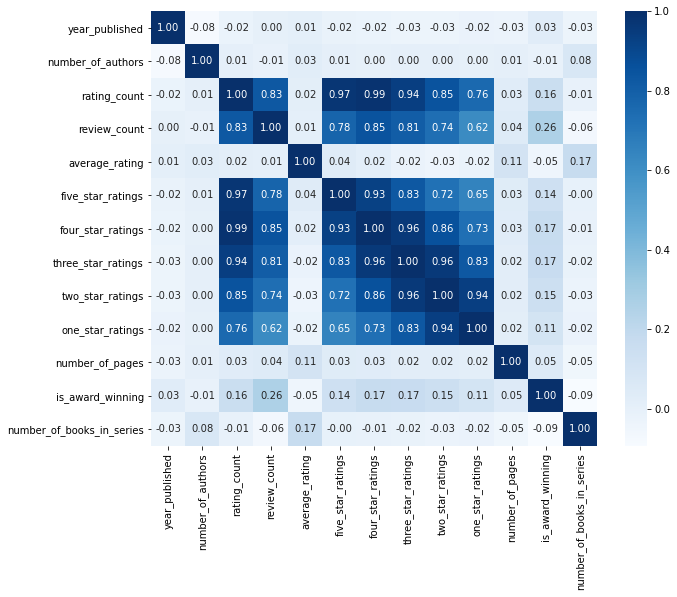

In [173]:
correlation_matrix = df.corr()

plt.rcParams['figure.figsize'] = (10,8)
sn.heatmap(correlation_matrix, annot = True, fmt = '.2f', cmap = 'Blues')
plt.show()

## Missing Values & Dummy Encoding (Numerical)

### Numerical

In [193]:
num_df = df.select_dtypes(include=['float', 'int'])
num_cols_lst = num_df.columns

method_0 = 'number_of_books_in_series'
method_mode = 'year_published'

for col in num_cols_lst:
    if col == method_0:
        df[col].fillna(0, inplace=True)
    elif col == method_mode:
        df[col].fillna((df[col].mode()[0]), inplace=True)
    else:
        df[col].fillna((df[col].mean()), inplace=True)

### Categorical

Use one-hot encoding instead of LabelEncoder or OrdinalEncoder from scikit.preprocessing, because the relevant categorical input is on a nominal scale.

In [194]:
cat_df = df.select_dtypes(include=['object'])
cat_cols_lst = cat_df.columns

for col in cat_cols_lst:
    try:
        # for each categorical variable add dummy variable, drop original column
        print("Processing column " + col)
        df = pd.concat([df.drop(col, axis=1), pd.get_dummies(df[col], prefix=col, prefix_sep='_', drop_first=True, dummy_na=True)],axis=1)
        print("Done")
    except:
        continue

Processing column publisher
Done
Processing column main_genre
Done


## ML Model

In [195]:
label_col = 'is_award_winning'
X = df.drop(label_col, axis=1)
y = df[label_col]

In [196]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.30, random_state=31)

# init classifier
clf40 = tree.DecisionTreeClassifier(max_depth = 3)

# timing classifier fit
t0 = time()
clf40 = clf40.fit(X_train, y_train)
print("training time:", round(time() - t0, 3), "s")

# timing classifier prediction
t0 = time()
pred40 = clf40.predict(X_test)
print("prediction time:", round(time() - t0, 3), "s")

# accuracy
print("test accuracy:", accuracy_score(y_test, pred40))
print("train accuracy:", accuracy_score(y_train, clf40.predict(X_train)))

training time: 24.383 s
prediction time: 2.364 s
test accuracy: 0.8264367816091954
train accuracy: 0.8207121158214511


In [242]:

# visualization of decision boundary (medium post)

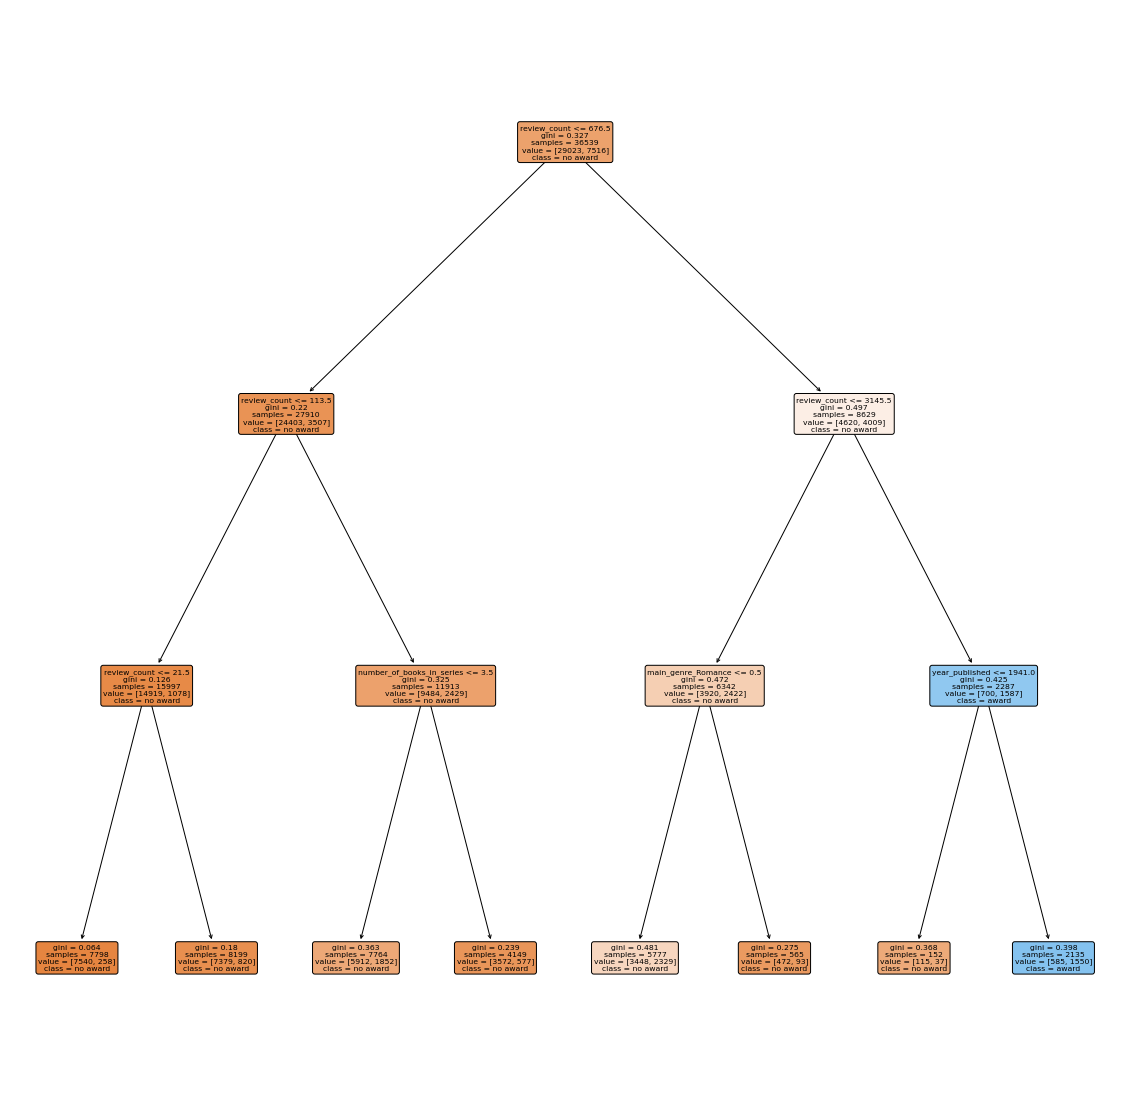

In [282]:
fig, ax = plt.subplots(figsize=(20, 20))
dt_plot = tree.plot_tree(clf40, 
                   feature_names = X.columns,
                   class_names=['no award', 'award'],
                   filled = True,
                   label='all',
                   rounded=True)

1 maximum depth computed.
2 maximum depth computed.
3 maximum depth computed.
4 maximum depth computed.
5 maximum depth computed.


[]

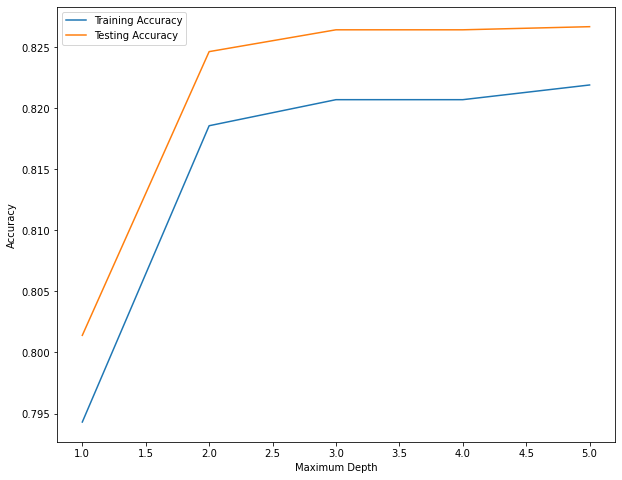

In [205]:
max_depth_list = [1,2,3,4,5]

train_errors = [] # Log training errors for each model
test_errors = [] # Log testing errors for each model

for x in max_depth_list:
    dtc = tree.DecisionTreeClassifier(max_depth=x) 
    dtc.fit(X_train,y_train)
    pred_train = dtc.predict(X_train)
    pred_test = dtc.predict(X_test)
    train_errors.append(accuracy_score(y_train, pred_train))
    test_errors.append(accuracy_score(y_test, pred_test))
    print(str(x) + ' maximum depth computed.')

x = np.arange(len(max_depth_list)) + 1 # Create domain for plot
plt.plot(x, train_errors, label='Training Accuracy') # Plot training error over domain
plt.plot(x, test_errors, label='Testing Accuracy') # Plot testing error over domain
plt.xlabel('Maximum Depth') # Label x-axis
plt.ylabel('Accuracy') # Label y-axis
plt.legend() # Show plot labels as legend
plt.plot() # Show graph